# Addestramento CNN con Data Augmentation per la Classificazione di Loghi Fake e Genuine

Questo progetto utilizza una rete neurale convoluzionale (CNN) e tecniche di data augmentation per classificare loghi autentici e falsi.

## 1. Importazione delle Librerie
Importiamo le librerie necessarie:
1. **TensorFlow e Keras**: Per creare e gestire la CNN.
2. **Matplotlib e Seaborn**: Per visualizzare i risultati.
3. **Scikit-learn**: Per calcolare la matrice di confusione e il classification report.
4. **OS e Shutil**: Per la gestione di file e directory.

In [1]:
import os
import shutil
import tensorflow as tf
from keras import layers, models
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## 2. Configurazione della Data Augmentation

In questa fase:
- Creiamo directory per le immagini aumentate.
- Configuriamo le trasformazioni da applicare.
- Generiamo immagini aumentate per entrambe le classi.

In [2]:
# Percorsi delle directory originali
train_dir = '/Users/ilaria/ProgettoDTM/archive2/train'
test_dir = '/Users/ilaria/ProgettoDTM/archive2/test'
train_genuine_dir = os.path.join(train_dir, 'Genuine')
train_fake_dir = os.path.join(train_dir, 'Fake')

# Directory per immagini aumentate
augmented_train_dir = '/Users/ilaria/ProgettoDTM/archive2/augmented_train'
augmented_genuine_dir = os.path.join(augmented_train_dir, 'Genuine')
augmented_fake_dir = os.path.join(augmented_train_dir, 'Fake')

os.makedirs(augmented_genuine_dir, exist_ok=True)
os.makedirs(augmented_fake_dir, exist_ok=True)

# Configurazione della data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Funzione per generare immagini aumentate
def generate_augmented_images(source_dir, output_dir, num_images):
    existing_images = os.listdir(source_dir)
    counter = 0
    for img_file in existing_images:
        img_path = os.path.join(source_dir, img_file)
        if img_file.endswith('.jpg'):  # Adatta l'estensione delle immagini
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            # Genera immagini aumentate
            for batch in datagen.flow(img_array, batch_size=1,
                                      save_to_dir=output_dir,
                                      save_prefix='aug',
                                      save_format='jpg'):
                counter += 1
                if counter >= num_images:
                    break
    print(f"Generazione completata: {counter} immagini salvate in {output_dir}")

# Genera più immagini per Genuine
generate_augmented_images(train_genuine_dir, augmented_genuine_dir, 1000)  # Numero desiderato

# Genera più immagini per Fake
generate_augmented_images(train_fake_dir, augmented_fake_dir, 1000)  # Numero desiderato

Generazione completata: 1219 immagini salvate in /Users/ilaria/ProgettoDTM/archive2/augmented_train/Genuine
Generazione completata: 1438 immagini salvate in /Users/ilaria/ProgettoDTM/archive2/augmented_train/Fake


## 3. Creazione della CNN Personalizzata

Definiamo la rete neurale convoluzionale (CNN) utilizzando Keras.

In [3]:
# Definizione della CNN personalizzata
def create_custom_cnn(input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Sigmoid per classificazione binaria
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Creazione del modello
custom_cnn = create_custom_cnn()

# Visualizza l'architettura del modello
custom_cnn.summary()

/Users/ilaria/anaconda3/envs/DTM/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,561 (49.36 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Addestramento del Modello

Addestriamo il modello utilizzando il dataset bilanciato e aumentato.

In [4]:
# Generatore per il dataset bilanciato e aumentato
augmented_train_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    augmented_train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Generatore per il test set (senza augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Importante per la matrice di confusione
)

# Addestramento del modello con il dataset bilanciato e aumentato
history = custom_cnn.fit(
    augmented_train_data,
    epochs=10,  # Puoi aumentare ulteriormente se necessario
    validation_data=test_data
)

# Valutazione sul test set
test_loss, test_acc = custom_cnn.evaluate(test_data)
print(f"Test Accuracy: {test_acc}")

Found 2499 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
Epoch 1/10


/Users/ilaria/anaconda3/envs/DTM/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - accuracy: 0.7782 - loss: 0.4433 - val_accuracy: 0.6061 - val_loss: 0.9421
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8938 - loss: 0.2741 - val_accuracy: 0.7091 - val_loss: 0.7051
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.9149 - loss: 0.2056 - val_accuracy: 0.7212 - val_loss: 0.5957
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.9283 - loss: 0.1753 - val_accuracy: 0.6909 - val_loss: 0.6098
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.9402 - loss: 0.1472 - val_accuracy: 0.7455 - val_loss: 0.5729
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.9478 - loss: 0.1225 - val_accuracy: 0.7636 - val_loss: 0.4987
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9617 - loss: 0.1027 - val_accuracy: 0.7697 - val_loss: 0.5424
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.9586 - loss: 0.1111 - val_accuracy: 0.751

## 5. Valutazione delle Performance

Calcoliamo la matrice di confusione e il classification report per analizzare le performance del modello.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


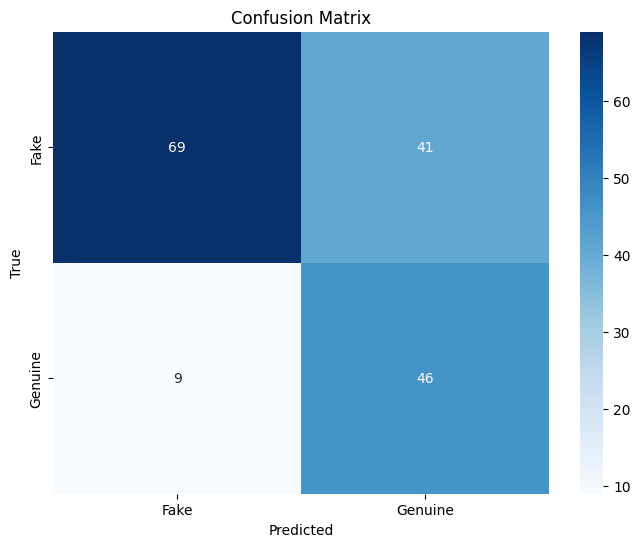

              precision    recall  f1-score   support

        Fake       0.88      0.63      0.73       110
     Genuine       0.53      0.84      0.65        55

    accuracy                           0.70       165
   macro avg       0.71      0.73      0.69       165
weighted avg       0.77      0.70      0.71       165



In [5]:

# Matrice di confusione
predictions = custom_cnn.predict(test_data)
predicted_classes = (predictions > 0.5).astype("int32")  # Converte probabilità in 0 o 1
true_classes = test_data.classes  # Classi reali
class_labels = list(test_data.class_indices.keys())  # Etichette delle classi

# Calcola la matrice di confusione
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

## 6. Visualizzazione dei Risultati

Visualizziamo i grafici dell'accuracy e della loss durante l'addestramento.

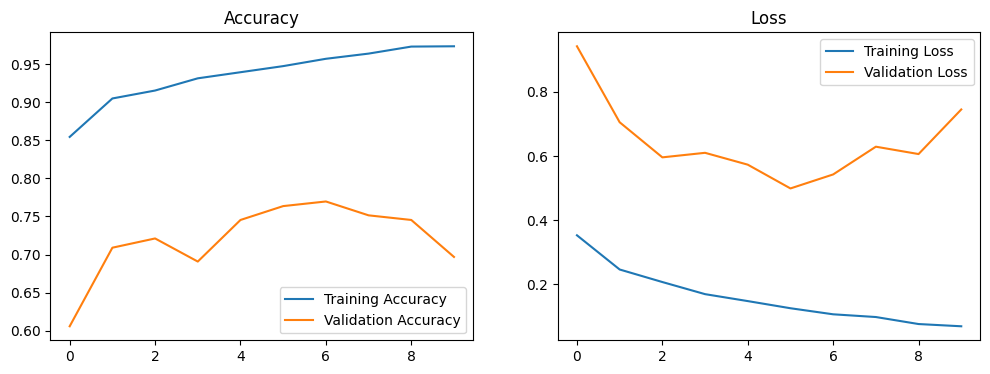

In [7]:
# Visualizzazione dei risultati
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()